In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

## Data preparation

In [3]:
df = pd.read_csv('../data/processed/cleaned_dataset.csv', thousands=',', index_col=0)

df.head()

,Household_Weekly_Expenditure,Monthly_Household_Income,Number_of_Household_Dependents,Age_of_Head_of_Household,Household_Size,Education_Level,Employment_Status,Location,Savings_Rate,Weekly_Savings,Monthly_Rent,Loan_Repayment,Transport_Expenses,Utility_Bills
0,391.15,1000.00,5.0,38.0,7.000000,High School,Unemployed,Urban,0.26,376.26,1790.00,404.60,131.170000,193.06
1,553.82,4958.45,3.0,59.0,6.037438,Master's,Employed,Suburban,0.29,351.83,1408.59,492.12,296.120000,269.79
2,710.45,6459.93,6.0,53.0,8.000000,Master's,Employed,Urban,0.29,431.85,1000.42,549.64,174.825609,240.01
3,639.76,6871.41,3.0,36.0,5.000000,Doctorate,Unemployed,Suburban,0.26,480.82,862.12,239.42,61.830000,306.85
4,473.14,4783.66,7.0,42.0,9.000000,Bachelor's,Employed,Suburban,0.05,61.29,1602.23,378.17,61.250000,374.29


We need to discretize the continuous values existing in our discrete columns because of preprocessing procedures

In [4]:
discrete_cols = ['Number_of_Household_Dependents', "Age_of_Head_of_Household", "Household_Size"]

df[discrete_cols] = df[discrete_cols].apply(round)

In [5]:
cat = df.nunique()[df.nunique() < 10]
cat = cat.index.tolist()
cat

['Number_of_Household_Dependents',
 'Household_Size',
 'Education_Level',
 'Employment_Status',
 'Location']

In [6]:
pca_df = df.drop(columns=cat)
data_matrix = pca_df.to_numpy()

## PCA

**Principal Component Analysis (PCA)** is the process of reducing a space of variables into a smaller space with little variance loss. It is achieved in a set of steps as follows.

## 1. Standardization

The first step is so center our data so that the *mean $\mu$* equals zero, and scale it so that the *standard deviation $\sigma$* equals one, using Z-score normalization, for which the formula is:

$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$

Where $X$ is our sample space, $\mu$ and $\sigma$ are the mean and standard deviation of $X$, respectively.

In [7]:
def scale(X):
  return (X - X.mean()) / X.std()

In [8]:
scaled_data_matrix = np.apply_along_axis(scale, 0, data_matrix)

In [9]:
scaled_data_matrix

array([[-5.51998727e-01, -1.71315790e+00, -7.16189002e-01, ...,
        -3.37920239e-01, -6.29225640e-01, -6.92227498e-01],
       [ 4.01235003e-01,  1.81969841e-01,  9.80462437e-01, ...,
        -1.69032451e-02,  1.76191411e+00,  2.44737515e-01],
       [ 1.31907480e+00,  9.00810901e-01,  4.95704883e-01, ...,
         1.94075931e-01,  3.61257087e-03, -1.18911880e-01],
       ...,
       [-4.63865480e-01,  7.75434897e-04, -1.50638523e-01, ...,
        -1.01325901e+00, -4.85713767e-01, -5.61934044e-01],
       [ 1.77146088e+00,  1.46127981e+00,  1.46521999e+00, ...,
        -1.71548368e+00, -1.23748405e+00,  1.36963282e+00],
       [ 3.66192661e-01,  1.08868739e-01,  6.57290734e-01, ...,
        -1.18376438e-03, -4.44162595e-03,  1.33971539e+00]],
      shape=(3941, 9))

We can verify by checking the mean and standard deviation for our new, scaled data columns

In [10]:
print(np.apply_along_axis(lambda col: {'mean': col.mean(), 'std': col.std()}, 0, scaled_data_matrix))

[{'mean': np.float64(2.1635404286021829e-16), 'std': np.float64(1.0)}
 {'mean': np.float64(-7.211801428673942e-17), 'std': np.float64(0.9999999999999999)}
 {'mean': np.float64(2.4520124857491404e-16), 'std': np.float64(1.0)}
 {'mean': np.float64(1.0231743276931156e-16), 'std': np.float64(1.0)}
 {'mean': np.float64(-1.1674103562665945e-16), 'std': np.float64(1.0)}
 {'mean': np.float64(8.811919870660974e-16), 'std': np.float64(1.0)}
 {'mean': np.float64(-2.7044255357527286e-17), 'std': np.float64(1.0)}
 {'mean': np.float64(9.104899303700852e-17), 'std': np.float64(0.9999999999999999)}
 {'mean': np.float64(-3.0650156071864255e-17), 'std': np.float64(1.0)}]


## 2. Covariance Matrix

PCA captures the direction that maximize variance, we therefore need to compute the *covariance matrix*, given by the formula:

$$
\Sigma = \frac{1}{n - 1} X^T X
$$

Where $n$ is the number of samples (observations)

In [11]:
sigma = (1 / scaled_data_matrix.shape[0]) * scaled_data_matrix.T @ scaled_data_matrix
sigma.shape

(9, 9)

We get a $9\times9$ matrix in which each number lying on the $i^\text{th}$ row and the $j^\text{th}$ column, is the covariance between components (features) $i$ and $j$

## 3. Eigenvalues and Eigenvectors

The eigenvalues of the covariance matrix represent the variance explained by each principal component. The corresponding eigenvector represents the direction of the component

In [12]:
eigenvalues, eigenvectors = np.linalg.eig(sigma)

## 4. Choosing the top-K Principal Components

The magnitudes of our eigenvalues determine how much variance the corresponding component explains on its own. We will therefore sort them in descending order.

In [13]:
eigenvalues_sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[eigenvalues_sorted_idx]
eigenvectors = eigenvectors[:, eigenvalues_sorted_idx]

In practice, we keep enough components to explain atleast 95% variance, thus, we will calculate the cumulative variance for our components.

In [14]:
explained_variance_ratio = eigenvalues / eigenvalues.sum()
cumulative_var = np.cumsum(explained_variance_ratio)
k = len(cumulative_var[cumulative_var < 0.95]) + 1
k

7

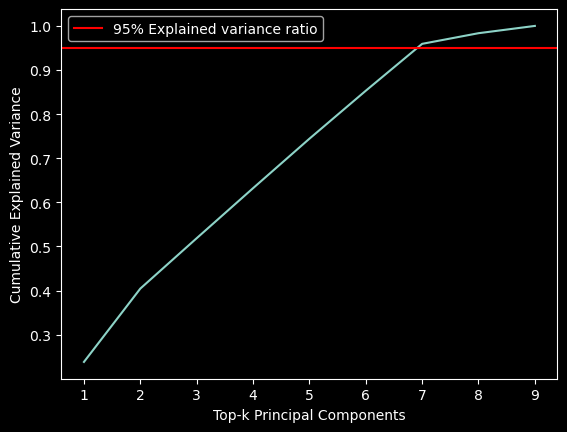

In [ ]:
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), cumulative_var)
plt.axhline(0.95, c="r", label="95% Explained variance ratio")
plt.xlabel("Top-k Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.show()

We can see that in our case, the top 7 principal components explain 95% of the variance, we will therefore set $k = 7$

## 5. Projection onto Principal Components

We will now represent our features in a space consisting only of the top-$k$ principal components, with the formula:

$$
X_\text{new} = X_\text{scaled}\cdot V_k
$$

Where $V_k$ contains the top-$k$ eigenvectors.

In [16]:
v_k = eigenvectors[:, :k]
X_new = scaled_data_matrix @ v_k

# Final Results

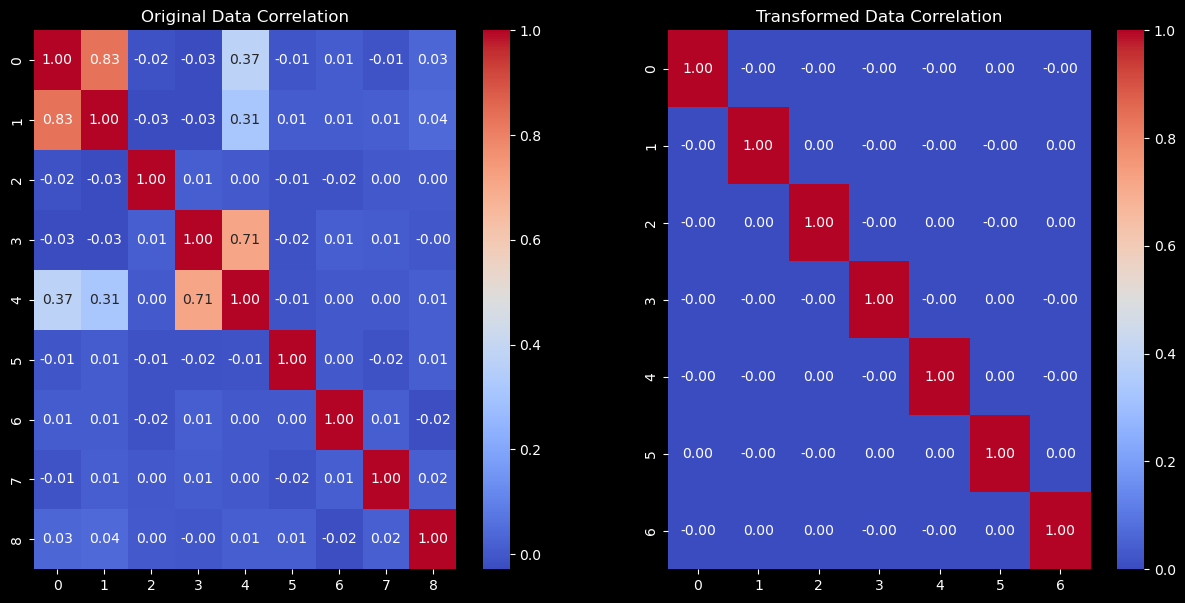

In [17]:
plt.style.use('dark_background')

corr_ = np.corrcoef(data_matrix.T)
corr = np.corrcoef(X_new.T)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].set_title('Original Data Correlation')
sns.heatmap(corr_, cmap='coolwarm', annot=True, fmt='.2f', ax=axes[0])
axes[1].set_title('Transformed Data Correlation')
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', ax=axes[1])
plt.show()

As we can see, there are relatively stronger absolute correlations in our original data matrix in comparison to the final matrix with the top 7 principal components, indicating stronger variance in the latter.